In [1]:
using Pkg
Pkg.activate("libs/")
# Pkg.instantiate()
# Pkg.add("MLUtils")
using CSV
using JLD2
using CUDA
using Glob
using Dates
# using Zygote
using DICOM
using Images
using MLUtils
using Setfield
using ImageView
using ImageDraw
using Statistics
using DataFrames
using StaticArrays
using MLDataPattern
using ChainRulesCore
using Distributions: Normal
using FastAI, FastVision, Flux, Metalhead
import CairoMakie; CairoMakie.activate!(type="png")

  Activating project at `~/Desktop/Project BAC/BAC project/libs`


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/molloi-lab/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/molloi-lab/snap/code/common/.cache/gio-modules/libgiolibproxy.so


Check how many threads we have

In [2]:
Threads.nthreads()

64

List all CUDA devices

In [3]:
CUDA.allowscalar(false)
CUDA.devices()

CUDA.DeviceIterator() for 4 devices:
0. NVIDIA GeForce RTX 4090
1. NVIDIA GeForce RTX 4090
2. NVIDIA GeForce RTX 4090
3. NVIDIA GeForce RTX 4090

# Notes

1. In this training, images' pixel values are zoomed into range = [0, 1]. This should not be applied to final plan since different images have different min and max.

2. In this training, only `pixel values` are being used. In future, we can feed more features to the NN to get a better information like `L_mass` or `R_mass`.

In [4]:
patch_size = 256
patch_size_half = round(Int, patch_size/2);

# Helper functions

In [5]:
"""
    This function zoom all pixel values into [0, 1].
"""
function zoom_pxiel_values(img)
    a, b = minimum(img), maximum(img)
    if b-a != 0
        img = (img .- a) / (b - a)
    end
    return img
end

zoom_pxiel_values

In [6]:
"""
    This function takes in a img of various size, 
    returns patches with size = patch_size * patch_size.
"""
function patch_image(img, lbl)
    s = size(img)
    x = ceil(Int, s[1]/patch_size) + floor(Int, (s[1]-patch_size_half)/patch_size)
    y = ceil(Int, s[2]/patch_size) + floor(Int, (s[2]-patch_size_half)/patch_size)
    num_patches = x*y
    img_patches = Array{Float32, 4}(undef, patch_size, patch_size, 1, num_patches)
    lbl_patches = Array{Float32, 4}(undef, patch_size, patch_size, 1, num_patches)
    ct = 0
    for i = 1 : x-1
        x_start = 1+(i-1)*patch_size_half
        x_end = x_start+patch_size-1
        for j = 1 : y-1
            y_start = 1+(j-1)*patch_size_half
            y_end = y_start+patch_size-1
            # save patch
            ct += 1
            img_patches[:, :, 1, ct] = zoom_pxiel_values(img[x_start:x_end, y_start:y_end])
            lbl_patches[:, :, 1, ct] = lbl[x_start:x_end, y_start:y_end]
        end
        # right col
        y_start, y_end = s[2]-patch_size+1, s[2]
        # save patch
        ct += 1
        img_patches[:, :, 1, ct] = zoom_pxiel_values(img[x_start:x_end, y_start:y_end])
        lbl_patches[:, :, 1, ct] = lbl[x_start:x_end, y_start:y_end]
    end
    # last row
    x_start, x_end = s[1]-patch_size+1, s[1]
    for j = 1 : y-1
        y_start = 1+(j-1)*patch_size_half
        y_end = y_start+patch_size-1
        # save patch
        ct += 1
        img_patches[:, :, 1, ct] = zoom_pxiel_values(img[x_start:x_end, y_start:y_end])
        lbl_patches[:, :, 1, ct] = lbl[x_start:x_end, y_start:y_end]
    end
    # right col
    y_start, y_end = s[2]-patch_size+1, s[2]
    # save patch
    ct += 1
    img_patches[:, :, 1, ct] = zoom_pxiel_values(img[x_start:x_end, y_start:y_end])
    lbl_patches[:, :, 1, ct] = lbl[x_start:x_end, y_start:y_end]
    # return
    return num_patches, img_patches, lbl_patches
end

patch_image

In [7]:
"""
    This function fixs the path to the images and labels.
"""
function fix_path!(data_set)
    num_data = size(data_set)[1]
    Threads.@threads for i = 1 : num_data
        for j = 1 : 2
            for k = 1 : 4
                # modify img path
                splited = split(deepcopy(data_set[i][j][k]), "\\")
                if size(splited)[1] > 1
                    new_path = joinpath("../collected_dataset_for_ML", joinpath(splited[4:end]))
                    data_set[i][j][k] = new_path
                end
            end
        end
    end
end

fix_path!

In [8]:
"""
    This function check how many number of images and labels there will be after patching.
"""
function get_num_of_imgs(data_set)
    num_data = size(data_set)[1]
    cts = Array{Int}(undef, num_data*4)
    Threads.@threads for i = 1 : num_data
        @views t = train_set[i]
        for j = 1 : 4
            # read dicom images
            s = size(dcm_parse(t[1][j])[(0x7fe0, 0x0010)])
            x = ceil(Int, s[1]/patch_size) + floor(Int, (s[1]-patch_size_half)/patch_size)
            y = ceil(Int, s[2]/patch_size) + floor(Int, (s[2]-patch_size_half)/patch_size)
            # save 
            cts[(i-1)*4+j] = x*y
        end
    end
    return cts
end

get_num_of_imgs

# 1. Prepare

In [9]:
@load "clean_set_step2_for_ubuntu.jld2" train_set valid_set

2-element Vector{Symbol}:
 :train_set
 :valid_set

In [10]:
data_dir = "../collected_dataset_for_ML";

Check if dataset is found

In [11]:
isdir(data_dir)

true

## 1.1 Load train set & valid set
container format: patch_size * patch_size * 1 * num_imgs

In [12]:
# get num of total patches(train)
ct_patches_train = get_num_of_imgs(train_set)
num_patches_train = sum(ct_patches_train)

703276

In [13]:
# runtime: 50s
num_train_data = size(train_set)[1]
train_container_images = Array{Float16, 4}(undef, patch_size, patch_size, 1, num_patches_train)
train_container_masks = Array{Float16, 4}(undef, patch_size, patch_size, 1, num_patches_train)
Threads.@threads for i = 1 : num_train_data
    start_idx = sum(ct_patches_train[1:i-1])+1
    for j = 1 : 4 # 4 images each patient
        # read dicom images
        img = Float16.(dcm_parse(train_set[i][1][j])[(0x7fe0, 0x0010)])
        # read png images
        lbl = Float16.(Images.load(train_set[i][2][j]))
        # process image
        num_patches, img_patches, lbl_patches = patch_image(img, lbl)
        # save 
        end_idx = start_idx+num_patches-1
        train_container_images[:, :, 1, start_idx : end_idx] = img_patches
        train_container_masks[:, :, 1, start_idx : end_idx] = lbl_patches
        start_idx = end_idx
    end
end

In [14]:
# get num of total patches(valid)
ct_patches_valid = get_num_of_imgs(valid_set)
num_patches_valid = sum(ct_patches_valid)

113564

In [15]:
# runtime: 7.5s
num_valid_data = size(valid_set)[1]
valid_container_images = Array{Float16, 4}(undef, patch_size, patch_size, 1, num_patches_valid)
valid_container_masks = Array{Float16, 4}(undef, patch_size, patch_size, 1, num_patches_valid)
Threads.@threads for i = 1 : num_valid_data
    start_idx = sum(ct_patches_valid[1:i-1])+1
    for j = 1 : 4 # 4 images each patient
        # read dicom images
        img = Float16.(dcm_parse(valid_set[i][1][j])[(0x7fe0, 0x0010)])
        # read png images
        lbl = Float16.(Images.load(valid_set[i][2][j]))
        # process image
        num_patches, img_patches, lbl_patches = patch_image(img, lbl)
        # save 
        end_idx = start_idx+num_patches-1
        valid_container_images[:, :, 1, start_idx : end_idx] = img_patches
        valid_container_masks[:, :, 1, start_idx : end_idx] = lbl_patches
        start_idx = end_idx
    end
end

In [16]:
GC.gc(true)

## 1.2 Create dataloaders

In [17]:
b_s = 10
batch_size = b_s*4
# batch_size = 20
train_loader = MLUtils.DataLoader((data=train_container_images, label=train_container_masks), batchsize=batch_size)
test_loader = MLUtils.DataLoader((data=valid_container_images, label=valid_container_masks), batchsize=b_s);

## 1.3 Create Model

In [18]:
function _random_normal(shape...)
    return Float16.(rand(Normal(0.0,0.02),shape...))
end

# _conv = (stride, in, out) -> Conv((3, 3), in=>out, stride=stride, pad=SamePad();init=_random_normal)
# _tran = (stride, in, out) -> ConvTranspose((2, 2), in=>out, stride=stride, pad=SamePad();init=_random_normal)
_conv = (stride, in, out) -> Conv((3, 3), in=>out, stride=stride, pad=SamePad())
_tran = (stride, in, out) -> ConvTranspose((2, 2), in=>out, stride=stride, pad=SamePad())

conv1 = (in, out) -> Chain(_conv(1, in, out), BatchNorm(out, leakyrelu))
conv2 = (in, out) -> Chain(_conv(2, in, out), BatchNorm(out, leakyrelu))
conv3 = (in, out) -> Chain(_conv(1, in, out), x -> softmax(x; dims = 3))
# conv3 = (in, out) -> Chain(_conv(1, in, out), sigmoid)
tran2 = (in, out) -> Chain(_tran(2, in, out), BatchNorm(out, leakyrelu))



function unet2D(in_chs, lbl_chs)
    # Contracting layers
    l1 = Chain(conv1(in_chs, 64), conv1(64, 64))
    l2 = Chain(l1, MaxPool((2,2), stride=2), conv1(64, 128), conv1(128, 128))
    l3 = Chain(l2, MaxPool((2,2), stride=2), conv1(128, 256), conv1(256, 256))
    l4 = Chain(l3, MaxPool((2,2), stride=2), conv1(256, 512), conv1(512, 512))
    l5 = Chain(l4, MaxPool((2,2), stride=2), conv1(512, 1024), conv1(1024, 1024), tran2(1024, 512))

    # Expanding layers
    l6 = Chain(Parallel(FastVision.Models.catchannels,l5,l4), 
                conv1(512+512, 512),
                conv1(512, 512),
                tran2(512, 256))
    l7 = Chain(Parallel(FastVision.Models.catchannels,l6,l3), 
                conv1(256+256, 256),
                conv1(256, 256),
                tran2(256, 128))
    l8 = Chain(Parallel(FastVision.Models.catchannels,l7,l2), 
                conv1(128+128, 128),
                conv1(128, 128),
                tran2(128, 64))
    l9 = Chain(Parallel(FastVision.Models.catchannels,l8,l1), 
                conv1(64+64, 64),
                conv1(64, 64),
                conv3(64, lbl_chs))
end

unet2D (generic function with 1 method)

## 1.4 Create Loss

In [19]:
function dice_loss(ŷ, y; ϵ=1f-5)
    # ŷ, y = Float32.(ŷ), Float32.(y)

    @inbounds loss_dice = 
        1f0 - (muladd(2f0, sum(ŷ[:,:,2,:] .* y[:,:,1,:]), ϵ) / (sum(ŷ[:,:,2,:] .^ 2) + sum(y[:,:,1,:] .^ 2) + ϵ))
    return loss_dice
    # loss_dice = 0f0
    # for chan_idx = 1 : 2
    #     @inbounds loss_dice += 
    #     1f0 - (muladd(2f0, sum(ŷ[:,:,chan_idx,:] .* y[:,:,chan_idx,:]), ϵ) / (sum(ŷ[:,:,chan_idx,:] .^ 2) + sum(y[:,:,chan_idx,:] .^ 2) + ϵ))
    # end
    # return loss_dice/2f0
end
lossfn = dice_loss
# lossfn = Flux.Losses.dice_coeff_loss

dice_loss (generic function with 1 method)

## 1.5 Loop

In [20]:
function data_parallel(device_id, x, y, model)
	device!(device_id)
	x_gpu = x |> gpu
	y_gpu = Float32.(y) |> gpu
	ls, gs = Flux.withgradient(Flux.params(model)) do 
		lossfn(model(x_gpu), y_gpu)
	end
	CUDA.unsafe_free!(x_gpu)
	CUDA.unsafe_free!(y_gpu)
	return ls, gs
end

# function update_params!(id_from, id_to, ps_from, ps_to)
# 	Threads.@threads for i = 1 : 90
# 		device!(id_from)
# 		p = ps_from[i] |> cpu
# 		device!(id_to)
# 		# ps_to[i] .= nothing
# 		ps_to[i] .= p |> gpu
# 	end
# end

function gradient_to_array(device_id, gs)
    device!(device_id)
    gs_array_gpu = [gs[p] for p in gs.params]
	gs_array_cpu = gs_array_gpu |> cpu
	Threads.@threads for i = 1 : 90
		CUDA.unsafe_free!(gs_array_gpu[i])
	end
	for p in gs.params
		CUDA.unsafe_free!(gs.grads[p])
		# CUDA.unsafe_free!(p)
	end

    device!(0)
    return gs_array_cpu |> gpu
end

function train_1_epoch!(epoch_idx, model_gpu0, model_gpu1, model_gpu2, model_gpu3, train_dl, optimizer)
	
	# Epoch start
	losses = Float32[]
	step_ct = 0
	for (x, y) in train_dl
		gs, gs_gpu0, gs_gpu1, gs_gpu2, gs_gpu3 = nothing, nothing, nothing, nothing, nothing
		ls0, ls1, ls2, ls3 = nothing, nothing, nothing, nothing
		@sync begin
			# Step start
			@async begin
				x_gpu0, y_gpu0 = x[:, :, :, 1:10], y[:, :, :, 1:10]
				ls0, gs = data_parallel(0, x_gpu0, y_gpu0, model_gpu0)
				gs_gpu0 = [gs[p] for p in gs.params]
			end
			@async begin
				x_gpu1, y_gpu1 = x[:, :, :, 11:20], y[:, :, :, 11:20]
				ls1, gs_gpu1_temp = data_parallel(1, x_gpu1, y_gpu1, model_gpu1)
				gs_gpu1 = gradient_to_array(1, gs_gpu1_temp)
			end
			@async begin
				x_gpu2, y_gpu2 = x[:, :, :, 21:30], y[:, :, :, 21:30]
				ls2, gs_gpu2_temp = data_parallel(2, x_gpu2, y_gpu2, model_gpu2)
				gs_gpu2 = gradient_to_array(2, gs_gpu2_temp)
			end
			@async begin
				x_gpu3, y_gpu3 = x[:, :, :, 31:end], y[:, :, :, 31:end]
				ls3, gs_gpu3_temp = data_parallel(3, x_gpu3, y_gpu3, model_gpu3)
				gs_gpu3 = gradient_to_array(3, gs_gpu3_temp)
			end
		end
		# @info "step $step_ct\tloss = $ls0, $ls1, $ls2, $ls3"
		push!(losses, (ls0+ls1+ls2+ls3)/4)
		ls0, ls1, ls2, ls3 = nothing, nothing, nothing, nothing
		

		device!(0)
		gs_gpu0 = gs_gpu0 .+ gs_gpu1 .+ gs_gpu2 .+ gs_gpu3

		Threads.@threads for i = 1 : 90
			gs.grads[Flux.params(model_gpu0)[i]] .= gs_gpu0[i]
		end
		old_para = Flux.params(model_gpu0)
	  	Flux.update!(optimizer, old_para, gs)
		# model_gpu0.params = old_para
		model_cpu = model_gpu0 |> cpu

		# sync new params to GPUs
		@sync begin
			@async begin
				device!(0)
				for p in gs.params
					CUDA.unsafe_free!(gs.grads[p])
					# CUDA.unsafe_free!(p)
				end
				Threads.@threads for i = 1 : 90
					CUDA.unsafe_free!(gs_gpu0[i])
				end
			end
			@async begin
				device!(1)
				Threads.@threads for i = 1 : 90
					CUDA.unsafe_free!(gs_gpu1[i])
				end
				model_gpu1 = nothing
				model_gpu1 = model_cpu |> gpu
				# model_ps_gpu1 = Flux.params(model_gpu1)
				# update_params!(0, 1, model_ps_gpu0, model_ps_gpu1)
			end
			@async begin
				device!(2)
				Threads.@threads for i = 1 : 90
					CUDA.unsafe_free!(gs_gpu2[i])
				end
				model_gpu2 = nothing
				model_gpu2 = model_cpu |> gpu
				# model_ps_gpu2 = Flux.params(model_gpu2)
				# update_params!(0, 2, model_ps_gpu0, model_ps_gpu2)
			end
			@async begin
				device!(3)
				Threads.@threads for i = 1 : 90
					CUDA.unsafe_free!(gs_gpu3[i])
				end
				model_gpu3 = nothing
				model_gpu3 = model_cpu |> gpu
				# model_ps_gpu3 = Flux.params(model_gpu3)
				# update_params!(0, 3, model_ps_gpu0, model_ps_gpu3)
			end
		end
		gs, gs_gpu0, gs_gpu1, gs_gpu2, gs_gpu3 = nothing, nothing, nothing, nothing, nothing
		
	  	# Step finished
		step_ct += 1
		if step_ct % 1000 == 0 
			@info "step $step_ct\tloss = $(mean(losses))"
			losses = Float32[]
			GC.gc(true)
			CUDA.reclaim()
		end
		flush(stdout)
	end
	# Epoch finished
	# if epoch_idx % 5 == 0
	# 	@info "loss = $(mean(losses))"
	# end
	# return model_ps_gpu0, model_ps_gpu1, model_ps_gpu2, model_ps_gpu3
end

train_1_epoch! (generic function with 1 method)

In [21]:
# function report_loss(model, train_dl, valid_dl)
# 	# train set
# 	losses = []
# 	for (x, y) in train_dl
#         ignore_derivatives() do
#             y_cated = cat(Float16(1) .- y, y, dims = 3)
#             x = x |> gpu
#             pred_y = model(x) |> cpu
#             loss = lossfn(pred_y, y_cated)
#             push!(losses, loss)
#         end
# 	end
# 	println("train Loss = $(mean(losses))")
	
# 	# valid set
# 	losses = []
# 	for (x, y) in valid_dl
#         ignore_derivatives() do
#             y_cated = cat(Float16(1) .- y, y, dims = 3)
#             x = x |> gpu
#             pred_y = model(x) |> cpu
#             loss = lossfn(pred_y, y_cated)
#             push!(losses, loss)
#         end
# 	end
# 	println("Valid Loss = $(mean(losses))")
#     flush(stdout)
# end

# 2. Train

[:,:,1,:] --> background  
[:,:,2,:] --> foreground

In [22]:
# lossfn = dice_loss
model = unet2D(1, 2);

## 2.1 Debug

In [23]:
step_ct_sample = 0
for (x, y) in train_loader
    step_ct_sample += 1
    if step_ct_sample == 75
        global x_sample = x
        global y_sample = y
        # println(size(x))
        # println(typeof(x))
        # println(size(y))
        # println(typeof(y))
        break
    end
end

### 2.1.1 Debug for NAN in Loss function

In [72]:
device!(0)
model_test = model |> gpu
x_sample_gpu = x_sample |> gpu
y_sample_cated = Float32.(y_sample)
y_sample_pred = model_test(x_sample_gpu) |> cpu;

In [25]:
maximum(x_sample), minimum(x_sample)

(Float16(1.0), Float16(0.0))

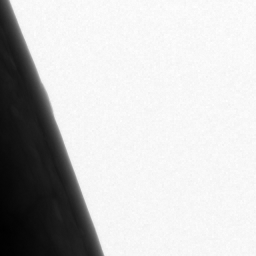

In [26]:
Gray.(zoom_pxiel_values(x_sample[:,:,1,2]))

In [27]:
maximum(y_sample_cated), minimum(y_sample_cated)

(0.0f0, 0.0f0)

In [28]:
maximum(y_sample_pred), minimum(y_sample_pred)

(0.5352258f0, 0.46477422f0)

In [29]:
chnl_idx = 2

2

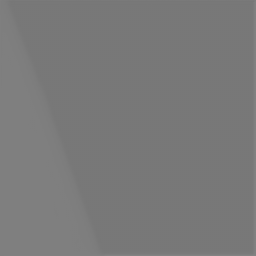

In [30]:
Gray.(y_sample_pred[:,:,chnl_idx,2])

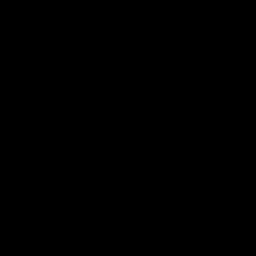

In [31]:
Gray.(y_sample_cated[:,:,1,2])

In [42]:
lossfn(y_sample_pred[:,:,:,2], y_sample_cated[:,:,:,2])

1.0f0

In [43]:
a = sum(y_sample_pred[:,:,chnl_idx,2] .* y_sample_cated[:,:,1,2])

0.0f0

In [44]:
b = sum(y_sample_pred[:,:,chnl_idx,2] .^ 2)

16410.203f0

In [45]:
c = sum(y_sample_cated[:,:,1,2] .^ 2)

0.0f0

In [46]:
d = (muladd(2f0, a, 1f-5) / (b + c + 1f-5))

6.0937694f-10

In [47]:
d_loss = 1f0 - d

1.0f0

### 2.1.2 Debug for GRAM leak

In [26]:
device!(0)
CUDA.memory_status() 

model_gpu0 = model |> gpu
x_gpu0, y_gpu0 = x_sample[:, :, :, 1:10], y_sample[:, :, :, 1:10]
y_gpu0 = Float32.(y_gpu0) |> gpu
x_gpu0 = x_gpu0 |> gpu
ls, gs = Flux.withgradient(Flux.params(model_gpu0)) do 
    lossfn(model_gpu0(x_gpu0), y_gpu0)
end

Effective GPU memory usage: 1.78% (404.312 MiB/22.159 GiB)
Memory pool usage: 0 bytes (0 bytes reserved)


(val = 1.0f0, grad = Grads(...))

In [36]:
device!(0)
CUDA.memory_status() 

Effective GPU memory usage: 90.17% (19.981 GiB/22.159 GiB)
Memory pool usage: 408.160 MiB (19.531 GiB reserved)


In [27]:
device!(3)
CUDA.memory_status() 

model_gpu3 = model |> gpu
x_gpu3, y_gpu3 = x_sample[:, :, :, 11:20], y_sample[:, :, :, 11:20]
y_gpu3 = Float32.(y_gpu3) |> gpu
x_gpu3 = x_gpu3 |> gpu
ls3, gs3 = Flux.withgradient(Flux.params(model_gpu3)) do 
    lossfn(model_gpu3(x_gpu3), y_gpu3)
end

Effective GPU memory usage: 1.78% (404.312 MiB/22.159 GiB)
Memory pool usage: 0 bytes (0 bytes reserved)


(val = 1.0f0, grad = Grads(...))

In [33]:
device!(3)
CUDA.memory_status() 

Effective GPU memory usage: 99.90% (22.137 GiB/22.159 GiB)
Memory pool usage: 17.330 GiB (21.688 GiB reserved)


In [37]:
device!(0)
gs_gpu0 = [gs[p] for p in gs.params]
CUDA.memory_status() 

Effective GPU memory usage: 90.17% (19.981 GiB/22.159 GiB)
Memory pool usage: 408.160 MiB (19.531 GiB reserved)


In [38]:
device!(3)
gs_gpu3 = gradient_to_array(3, gs3)
CUDA.memory_status() 

Effective GPU memory usage: 90.17% (19.981 GiB/22.159 GiB)
Memory pool usage: 526.588 MiB (19.531 GiB reserved)


In [40]:
device!(0)
gs_gpu0 = gs_gpu0 .+ gs_gpu3
CUDA.memory_status() 

Effective GPU memory usage: 90.17% (19.981 GiB/22.159 GiB)
Memory pool usage: 763.446 MiB (19.531 GiB reserved)


In [41]:
optimizer = AdaGrad(0.01)
device!(0)
Threads.@threads for i = 1 : 90
    gs.grads[Flux.params(model_gpu0)[i]] .= gs_gpu0[i]
end
old_para = Flux.params(model_gpu0)
Flux.update!(optimizer, old_para, gs)
model_cpu = model_gpu0 |> cpu
CUDA.memory_status() 

Effective GPU memory usage: 90.22% (19.991 GiB/22.159 GiB)
Memory pool usage: 763.446 MiB (19.531 GiB reserved)


In [42]:
device!(0)
for p in gs.params
    CUDA.unsafe_free!(gs.grads[p])
    # CUDA.unsafe_free!(p)
end
Threads.@threads for i = 1 : 90
    CUDA.unsafe_free!(gs_gpu0[i])
end
CUDA.memory_status() 

Effective GPU memory usage: 90.26% (20.000 GiB/22.159 GiB)
Memory pool usage: 526.588 MiB (19.531 GiB reserved)


In [43]:
device!(3)
Threads.@threads for i = 1 : 90
    CUDA.unsafe_free!(gs_gpu3[i])
end
model_gpu3 = nothing
model_gpu3 = model_cpu |> gpu
CUDA.memory_status() 

Effective GPU memory usage: 99.95% (22.147 GiB/22.159 GiB)
Memory pool usage: 245.712 MiB (21.688 GiB reserved)


In [44]:
gs, gs_gpu0, gs_gpu1, gs_gpu2, gs_gpu3 = nothing, nothing, nothing, nothing, nothing
device!(0)
CUDA.memory_status() 

Effective GPU memory usage: 90.26% (20.000 GiB/22.159 GiB)
Memory pool usage: 408.160 MiB (19.531 GiB reserved)


Effective GPU memory usage: 95.95% (21.262 GiB/22.159 GiB)
Memory pool usage: 18.358 GiB (20.812 GiB reserved)


In [82]:
CUDA.unsafe_free!(x_sample)
CUDA.unsafe_free!(y_sample_cated)
CUDA.memory_status() 

Effective GPU memory usage: 95.95% (21.262 GiB/22.159 GiB)
Memory pool usage: 18.355 GiB (20.812 GiB reserved)


In [83]:
CUDA.reclaim()
CUDA.memory_status() 

Effective GPU memory usage: 94.26% (20.887 GiB/22.159 GiB)
Memory pool usage: 18.355 GiB (20.438 GiB reserved)


In [90]:
model_test = nothing
GC.gc(true)
CUDA.memory_status() 

Effective GPU memory usage: 94.26% (20.887 GiB/22.159 GiB)
Memory pool usage: 0 bytes (20.438 GiB reserved)


In [91]:
CUDA.reclaim()
CUDA.memory_status() 

Effective GPU memory usage: 2.03% (460.375 MiB/22.159 GiB)
Memory pool usage: 0 bytes (0 bytes reserved)


In [92]:
gs = nothing
GC.gc(true)
CUDA.memory_status() 

Effective GPU memory usage: 2.03% (460.375 MiB/22.159 GiB)
Memory pool usage: 0 bytes (0 bytes reserved)


In [93]:
CUDA.reclaim()
CUDA.memory_status() 

Effective GPU memory usage: 2.03% (460.375 MiB/22.159 GiB)
Memory pool usage: 0 bytes (0 bytes reserved)


## 2.2 Actual train

In [23]:
device!(0)
model_0 = model |> gpu
# model_ps_0 = Flux.params(model_0)
device!(1)
model_1 = model |> gpu
# model_ps_1 = Flux.params(model_1)
device!(2)
model_2 = model |> gpu
# model_ps_2 = Flux.params(model_2)
device!(3)
model_3 = model |> gpu
# model_ps_3 = Flux.params(model_3);
""

""

In [24]:
model_test = nothing
x_sample = nothing
y_sample = nothing
device!(0)
CUDA.reclaim()
device!(1)
CUDA.reclaim()
device!(2)
CUDA.reclaim()
device!(3)
CUDA.reclaim()
GC.gc(true)
device!(0)

CuDevice(0): NVIDIA GeForce RTX 4090

In [25]:
# @sync begin
#     # Step start
#     @async begin
#         device!(0)
#         global model_0 = model |> gpu
#         global model_ps_0 = Flux.params(model_0)
#     end
#     @async begin
#         device!(1)
#         global model_1 = model |> gpu
#         global model_ps_1 = Flux.params(model_1)
#     end
#     @async begin
#         device!(2)
#         global model_2 = model |> gpu
#         global model_ps_2 = Flux.params(model_2)
#     end
#     @async begin
#         device!(3)
#         global model_3 = model |> gpu
#         global model_ps_3 = Flux.params(model_3)
#     end
# end
# modelss = [model_0, model_1, model_2, model_3]
# model_pss = [model_ps_0, model_ps_1, model_ps_2, model_ps_3];

In [26]:
optimizer = AdaGrad(0.01)

AdaGrad(0.01, 1.0e-8, IdDict{Any, Any}())

In [32]:
train_1_epoch!(1, model_0, model_1, model_2, model_3, train_loader, optimizer)

CompositeException: TaskFailedException

    nested task error: Out of GPU memory trying to allocate 160.563 MiB
    Effective GPU memory usage: 99.95% (22.147 GiB/22.159 GiB)
    Memory pool usage: 12.810 GiB (21.625 GiB reserved)
    
    Stacktrace:
       [1] macro expansion
         @ ~/.julia/packages/CUDA/pCcGc/src/pool.jl:424 [inlined]
       [2] macro expansion
         @ ./timing.jl:393 [inlined]
       [3] #_alloc#989
         @ ~/.julia/packages/CUDA/pCcGc/src/pool.jl:413 [inlined]
       [4] _alloc
         @ ~/.julia/packages/CUDA/pCcGc/src/pool.jl:408 [inlined]
       [5] #alloc#988
         @ ~/.julia/packages/CUDA/pCcGc/src/pool.jl:398 [inlined]
       [6] alloc
         @ ~/.julia/packages/CUDA/pCcGc/src/pool.jl:392 [inlined]
       [7] CuArray{UInt8, 1, CUDA.Mem.DeviceBuffer}(#unused#::UndefInitializer, dims::Tuple{Int64})
         @ CUDA ~/.julia/packages/CUDA/pCcGc/src/array.jl:93
       [8] CuArray
         @ ~/.julia/packages/CUDA/pCcGc/src/array.jl:176 [inlined]
       [9] CuArray
         @ ~/.julia/packages/CUDA/pCcGc/src/array.jl:183 [inlined]
      [10] with_workspace(f::NNlibCUDA.var"#31#33"{Base.RefValue{Float32}, Base.RefValue{Float32}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, cuDNN.cudnnConvolutionBwdDataAlgoPerfStruct, cuDNN.cudnnFilterDescriptor, cuDNN.cudnnTensorDescriptor, cuDNN.cudnnTensorDescriptor, cuDNN.cudnnConvolutionDescriptor}, eltyp::Type{UInt8}, size::CUDA.APIUtils.var"#2#3"{UInt64}, fallback::Nothing; keep::Bool)
         @ CUDA.APIUtils ~/.julia/packages/CUDA/pCcGc/lib/utils/call.jl:67
      [11] with_workspace(f::Function, eltyp::Type{UInt8}, size::CUDA.APIUtils.var"#2#3"{UInt64}, fallback::Nothing)
         @ CUDA.APIUtils ~/.julia/packages/CUDA/pCcGc/lib/utils/call.jl:58
      [12] #with_workspace#1
         @ ~/.julia/packages/CUDA/pCcGc/lib/utils/call.jl:55 [inlined]
      [13] with_workspace
         @ ~/.julia/packages/CUDA/pCcGc/lib/utils/call.jl:55 [inlined]
      [14] with_workspace(f::Function, size::UInt64)
         @ CUDA.APIUtils ~/.julia/packages/CUDA/pCcGc/lib/utils/call.jl:55
      [15] ∇conv_data!(dx::CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, dy::CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, w::CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, cdims::DenseConvDims{2, 2, 2, 4, 2}; alpha::Int64, beta::Int64, algo::Int64)
         @ NNlibCUDA ~/.julia/packages/NNlibCUDA/C6t0p/src/cudnn/conv.jl:101
      [16] ∇conv_data!
         @ ~/.julia/packages/NNlibCUDA/C6t0p/src/cudnn/conv.jl:89 [inlined]
      [17] #∇conv_data#241
         @ ~/.julia/packages/NNlib/Fg3DQ/src/conv.jl:99 [inlined]
      [18] ∇conv_data
         @ ~/.julia/packages/NNlib/Fg3DQ/src/conv.jl:95 [inlined]
      [19] #380
         @ ~/.julia/packages/NNlib/Fg3DQ/src/conv.jl:350 [inlined]
      [20] unthunk
         @ ~/.julia/packages/ChainRulesCore/0t04l/src/tangent_types/thunks.jl:204 [inlined]
      [21] wrap_chainrules_output
         @ ~/.julia/packages/Zygote/JeHtr/src/compiler/chainrules.jl:110 [inlined]
      [22] map
         @ ./tuple.jl:275 [inlined]
      [23] map
         @ ./tuple.jl:276 [inlined]
      [24] wrap_chainrules_output
         @ ~/.julia/packages/Zygote/JeHtr/src/compiler/chainrules.jl:111 [inlined]
      [25] ZBack
         @ ~/.julia/packages/Zygote/JeHtr/src/compiler/chainrules.jl:211 [inlined]
      [26] Pullback
         @ ~/.julia/packages/Flux/n3cOc/src/layers/conv.jl:202 [inlined]
      [27] (::Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}})(Δ::CuArray{Float32, 4, CUDA.Mem.DeviceBuffer})
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/compiler/interface2.jl:0
      [28] macro expansion
         @ ~/.julia/packages/Flux/n3cOc/src/layers/basic.jl:53 [inlined]
      [29] Pullback
         @ ~/.julia/packages/Flux/n3cOc/src/layers/basic.jl:53 [inlined]
      [30] (::Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}})(Δ::CuArray{Float32, 4, CUDA.Mem.DeviceBuffer})
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/compiler/interface2.jl:0
      [31] Pullback
         @ ~/.julia/packages/Flux/n3cOc/src/layers/basic.jl:51 [inlined]
    --- the last 5 lines are repeated 3 more times ---
      [47] (::Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}})(Δ::CuArray{Float32, 4, CUDA.Mem.DeviceBuffer})
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/compiler/interface2.jl:0
      [48] Pullback
         @ ~/.julia/packages/Flux/n3cOc/src/layers/basic.jl:527 [inlined]
      [49] (::Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}})(Δ::CuArray{Float32, 4, CUDA.Mem.DeviceBuffer})
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/compiler/interface2.jl:0
      [50] #676
         @ ~/.julia/packages/Zygote/JeHtr/src/lib/array.jl:215 [inlined]
      [51] map
         @ ./tuple.jl:299 [inlined]
      [52] (::Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 5, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}})(Δ::Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}})
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/lib/array.jl:215
      [53] (::Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 5, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}})(Δ::Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}})
         @ Zygote ~/.julia/packages/ZygoteRules/OgCVT/src/adjoint.jl:71
      [54] Pullback
         @ ~/.julia/packages/Flux/n3cOc/src/layers/basic.jl:527 [inlined]
      [55] (::Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 5, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}})(Δ::CuArray{Float32, 4, CUDA.Mem.DeviceBuffer})
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/compiler/interface2.jl:0
      [56] macro expansion
         @ ~/.julia/packages/Flux/n3cOc/src/layers/basic.jl:53 [inlined]
      [57] Pullback
         @ ~/.julia/packages/Flux/n3cOc/src/layers/basic.jl:53 [inlined]
      [58] (::Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 5, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}})(Δ::CuArray{Float32, 4, CUDA.Mem.DeviceBuffer})
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/compiler/interface2.jl:0
      [59] Pullback
         @ ~/.julia/packages/Flux/n3cOc/src/layers/basic.jl:51 [inlined]
    --- the last 13 lines are repeated 3 more times ---
      [99] (::Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 5, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{var"#34#36", CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#kw_zpullback#53"{NNlib.var"#softmax_pullback#207"{Int64, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:dims,)}}, Tuple{Int64}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:dims,), Tuple{Int64}}}, Tuple{Int64}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:dims,), Tuple{Int64}}, Nothing, true}}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, var"#34#36"}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}}}})(Δ::CuArray{Float32, 4, CUDA.Mem.DeviceBuffer})
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/compiler/interface2.jl:0
     [100] Pullback
         @ ~/Desktop/Project BAC/BAC project/4_train.ipynb:6 [inlined]
     [101] (::Zygote.Pullback{Tuple{var"#40#41"{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(dice_loss), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{var"##dice_loss#39", Float32, typeof(dice_loss), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#3882#back#1235"{Zygote.var"#1231#1234"{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#4197#back#1437"{Zygote.var"#1433#1436"{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2610#back#529"{Zygote.var"#539#541"{4, Float32, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Colon, Colon, Int64, Colon}}}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3882#back#1235"{Zygote.var"#1231#1234"{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float32, NamedTuple{(), Tuple{}}}, ProjectTo{Float32, NamedTuple{(), Tuple{}}}}}, Zygote.ZBack{Zygote.var"#plus_pullback#341"{Tuple{Float32, Float32, Float32}}}, Zygote.var"#1926#back#157"{Zygote.var"#153#156"}, Zygote.var"#2610#back#529"{Zygote.var"#539#541"{4, Float32, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Colon, Colon, Int64, Colon}}}, Zygote.ZBack{ChainRules.var"#muladd_pullback#1190"{Bool, Float32, Float32, ProjectTo{Float32, NamedTuple{(), Tuple{}}}, ProjectTo{Float32, NamedTuple{(), Tuple{}}}, ProjectTo{Float32, NamedTuple{(), Tuple{}}}}}, Zygote.var"#3802#back#1201"{Zygote.var"#1197#1200"{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#4197#back#1437"{Zygote.var"#1433#1436"{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2610#back#529"{Zygote.var"#539#541"{4, Float32, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Colon, Colon, Int64, Colon}}}, Zygote.ZBack{ChainRules.var"#/_pullback#1336"{Float32, Float32, ProjectTo{Float32, NamedTuple{(), Tuple{}}}, ProjectTo{Float32, NamedTuple{(), Tuple{}}}}}, Zygote.var"#1926#back#157"{Zygote.var"#153#156"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#4197#back#1437"{Zygote.var"#1433#1436"{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2610#back#529"{Zygote.var"#539#541"{4, Float32, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Colon, Colon, Int64, Colon}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x_gpu, Zygote.Context{true}, var"#40#41"{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:y_gpu, Zygote.Context{true}, var"#40#41"{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:model, Zygote.Context{true}, var"#40#41"{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}}}, Zygote.var"#1990#back#190"{Zygote.var"#186#189"{Zygote.Context{true}, GlobalRef, typeof(dice_loss)}}, Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 5, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{var"#34#36", CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#kw_zpullback#53"{NNlib.var"#softmax_pullback#207"{Int64, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:dims,)}}, Tuple{Int64}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:dims,), Tuple{Int64}}}, Tuple{Int64}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:dims,), Tuple{Int64}}, Nothing, true}}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, var"#34#36"}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}}}}}})(Δ::Float32)
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/compiler/interface2.jl:0
     [102] (::Zygote.var"#118#119"{Zygote.Params{Zygote.Buffer{Any, Vector{Any}}}, Zygote.Pullback{Tuple{var"#40#41"{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(dice_loss), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{var"##dice_loss#39", Float32, typeof(dice_loss), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#3882#back#1235"{Zygote.var"#1231#1234"{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#4197#back#1437"{Zygote.var"#1433#1436"{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2610#back#529"{Zygote.var"#539#541"{4, Float32, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Colon, Colon, Int64, Colon}}}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3882#back#1235"{Zygote.var"#1231#1234"{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float32, NamedTuple{(), Tuple{}}}, ProjectTo{Float32, NamedTuple{(), Tuple{}}}}}, Zygote.ZBack{Zygote.var"#plus_pullback#341"{Tuple{Float32, Float32, Float32}}}, Zygote.var"#1926#back#157"{Zygote.var"#153#156"}, Zygote.var"#2610#back#529"{Zygote.var"#539#541"{4, Float32, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Colon, Colon, Int64, Colon}}}, Zygote.ZBack{ChainRules.var"#muladd_pullback#1190"{Bool, Float32, Float32, ProjectTo{Float32, NamedTuple{(), Tuple{}}}, ProjectTo{Float32, NamedTuple{(), Tuple{}}}, ProjectTo{Float32, NamedTuple{(), Tuple{}}}}}, Zygote.var"#3802#back#1201"{Zygote.var"#1197#1200"{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#4197#back#1437"{Zygote.var"#1433#1436"{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2610#back#529"{Zygote.var"#539#541"{4, Float32, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Colon, Colon, Int64, Colon}}}, Zygote.ZBack{ChainRules.var"#/_pullback#1336"{Float32, Float32, ProjectTo{Float32, NamedTuple{(), Tuple{}}}, ProjectTo{Float32, NamedTuple{(), Tuple{}}}}}, Zygote.var"#1926#back#157"{Zygote.var"#153#156"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#4197#back#1437"{Zygote.var"#1433#1436"{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2610#back#529"{Zygote.var"#539#541"{4, Float32, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Colon, Colon, Int64, Colon}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x_gpu, Zygote.Context{true}, var"#40#41"{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:y_gpu, Zygote.Context{true}, var"#40#41"{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:model, Zygote.Context{true}, var"#40#41"{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}}}, Zygote.var"#1990#back#190"{Zygote.var"#186#189"{Zygote.Context{true}, GlobalRef, typeof(dice_loss)}}, Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Nothing, false}}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, 1, Tuple{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Val{2}}, Tuple{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 5, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{5, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 4, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{MaxPool{2, 4}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:pad, Zygote.Context{true}, MaxPool{2, 4}, NTuple{4, Int64}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:k, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}, Zygote.var"#kw_zpullback#53"{NNlib.var"#PoolDims_pullback#375"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride)}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}}, Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:padding, :stride), Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}}, Nothing, true}}}}}}, Zygote.ZBack{NNlib.var"#maxpool_pullback#480"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, PoolDims{2, 2, 2, 4, 2}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, MaxPool{2, 4}, Tuple{Int64, Int64}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, MaxPool{2, 4}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(lastindex), NTuple{4, Int64}}, Tuple{Zygote.ZBack{ChainRules.var"#length_pullback#747"}}}, Zygote.ZBack{ChainRules.var"#size_pullback#917"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2049#back#218"{Zygote.var"#back#216"{4, Zygote.Context{true}, Int64, Int64}}}}, Zygote.ZBack{NNlib.var"#∇conv_data_pullback#388"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_transpose_dims_pullback#266"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Zygote.Pullback{Tuple{Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:x, Zygote.Context{true}, Flux.var"#227#228"{CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}, CuArray{Float16, 4, CUDA.Mem.DeviceBuffer}}}}}}}}}, Zygote.Pullback{Tuple{Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Zygote.Pullback{Tuple{typeof(convert), Type{Tuple}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:connection, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, typeof(FastVision.Models.catchannels)}}, Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing, Nothing}}, Zygote.Pullback{Tuple{typeof(FastVision.Models.catchannels), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Any}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Nothing}, Any}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 3, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 2, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{4, 1, Zygote.Context{true}, Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}}}, Zygote.Pullback{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux._applychain), Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.Pullback{Tuple{var"#34#36", CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#kw_zpullback#53"{NNlib.var"#softmax_pullback#207"{Int64, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{NamedTuple{(:dims,)}}, Tuple{Int64}}, Tuple{Zygote.Pullback{Tuple{Type{NamedTuple{(:dims,), Tuple{Int64}}}, Tuple{Int64}}, Tuple{Zygote.var"#2224#back#311"{Zygote.Jnew{NamedTuple{(:dims,), Tuple{Int64}}, Nothing, true}}}}}}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 2, Zygote.Context{true}, var"#34#36"}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{Zygote.ZBack{Flux.var"#177#178"}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.Pullback{Tuple{Type{Pair}, Int64, Int64}, Tuple{Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Core.convert), Type{Int64}, Int64}, Tuple{}}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.ZBack{ChainRules.var"#fieldtype_pullback#421"}, Zygote.var"#2214#back#309"{Zygote.Jnew{Pair{Int64, Int64}, Nothing, false}}}}, Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(Flux.conv_reshape_bias), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64}}, Tuple{Zygote.var"#2173#back#289"{Zygote.var"#287#288"{Tuple{Tuple{Nothing}, Tuple{Nothing, Nothing}, Tuple{Nothing, Nothing}}, Zygote.var"#2799#back#621"{Zygote.var"#615#619"{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Tuple{Int64, Int64, Colon, Int64}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2881#back#684"{Zygote.var"#map_back#678"{Flux.var"#250#251", 1, Tuple{Tuple{Int64, Int64}}, Tuple{Val{2}}, Tuple{Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}, Tuple{Int64, Zygote.Pullback{Tuple{Flux.var"#250#251", Int64}, Tuple{}}}}}}, Zygote.var"#2017#back#200"{typeof(identity)}, Zygote.var"#2214#back#309"{Zygote.Jnew{Flux.var"#250#251", Nothing, false}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:stride, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Tuple{Int64, Int64}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:bias, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}, Zygote.var"#3754#back#1177"{Zygote.var"#1171#1175"{Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}}, Zygote.Pullback{Tuple{typeof(NNlib.fast_act), typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#3898#back#1243"{Zygote.var"#1239#1242"}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.Pullback{Tuple{typeof(Flux._channels_in), Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}, Tuple{Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:groups, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, Int64}}, Zygote.ZBack{ChainRules.var"#size_pullback#919"}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:weight, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1346"{Int64, Int64}}, Zygote.ZBack{ChainRules.var"#-_pullback#1335"{Int64, Bool, ProjectTo{Float64, NamedTuple{(), Tuple{}}}, ProjectTo{Float64, NamedTuple{(), Tuple{}}}}}}}, Zygote.ZBack{NNlib.var"#conv_pullback#382"{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, DenseConvDims{2, 2, 2, 4, 2}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:σ, Zygote.Context{true}, Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, typeof(identity)}}, Zygote.ZBack{Flux.var"#_size_check_pullback#204"{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, Pair{Int64, Int64}}}}, Zygote.Pullback{Tuple{typeof(ndims), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, Tuple{}}, Zygote.ZBack{Flux.var"#conv_dims_pullback#260"}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}, Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}}}}, Zygote.var"#2184#back#299"{Zygote.var"#back#298"{:layers, Zygote.Context{true}, Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}, Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}}}}}}}, Zygote.Context{true}})(Δ::Float32)
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/compiler/interface.jl:389
     [103] withgradient(f::Function, args::Zygote.Params{Zygote.Buffer{Any, Vector{Any}}})
         @ Zygote ~/.julia/packages/Zygote/JeHtr/src/compiler/interface.jl:133
     [104] data_parallel(device_id::Int64, x::Array{Float16, 4}, y::Array{Float16, 4}, model::Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Parallel{typeof(FastVision.Models.catchannels), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, MaxPool{2, 4}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}, Chain{Tuple{Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, BatchNorm{typeof(leakyrelu), CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, Float32, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}}}, Chain{Tuple{Conv{2, 4, typeof(identity), CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}, var"#34#36"}}}})
         @ Main ~/Desktop/Project BAC/BAC project/4_train.ipynb:5
     [105] macro expansion
         @ ~/Desktop/Project BAC/BAC project/4_train.ipynb:51 [inlined]

In [33]:
train_1_epoch!(2, model_0, model_1, model_2, model_3, train_loader, optimizer)

In [ ]:
train_1_epoch!(3, model_0, model_1, model_2, model_3, train_loader, optimizer)

In [ ]:
train_1_epoch!(4, model_0, model_1, model_2, model_3, train_loader, optimizer)

In [ ]:
train_1_epoch!(5, model_0, model_1, model_2, model_3, train_loader, optimizer)